# À propos de ce livret



Recherches liées au développement de cette méthode : 
> Ruslan Salakhutdinov, Andriy Mnih, 2008. [**Bayesian probabilistic matrix factorization using Markov chain Monte Carlo**](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf). 
>Proceedings of the 25th International Conference on Machine Learning (*ICML 2008*), Helsinki, Finland. [[Matlab code (official)](https://www.cs.toronto.edu/~rsalakhu/BPMF.html)]


La méthode implantés provient de ces sources : 
>[**Dépôt 1**](https://github.com/xinychen/transdim) *version python*  



**Note sur le cachier**



## Préparation préalable à l'utilisation

In [1]:
# Utilités
import os
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from numpy.linalg import inv as inv
import time

# Chargement des données
import scipy.io

# Barre de progression
from tqdm.auto import trange
from tqdm import tqdm_notebook, notebook

# Présentation des résultats
import matplotlib.pyplot as plt

In [2]:
os.chdir("C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application")

# Données

## Chargement des données

In [3]:
# Chargement du tenseur de données
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']

# Chargement de la matrice aléatoire de données
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

# Chargement du tenseur aléatoire de données
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

print("Tensor shape : {:} | Random matrix shape : {:} | Random tensor shape : {:}".format(tensor.shape, 
                                                                                        random_matrix.shape,
                                                                                        random_tensor.shape))

Tensor shape : (214, 61, 144) | Random matrix shape : (214, 61) | Random tensor shape : (214, 61, 144)


## Format des données

In [4]:
petit_donnees = True

# Paramètres du jeu de données tronqué
capteurs = 12
jours = 5
sequences = tensor.shape[2]

matrice = True

if petit_donnees == True:
    tensor = tensor[0:capteurs, 0:jours, 0:sequences]
    
    random_tensor = random_tensor[0:capteurs, 0:jours, 0:sequences]
    

print("The tensors shapes are : {:} | {:}".format(tensor.shape, random_tensor.shape))

if matrice == True:
    dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
    
    print("The matrix shape is : {:}".format(dense_mat.shape))

The tensors shapes are : (12, 5, 144) | (12, 5, 144)
The matrix shape is : (12, 720)


## Scénario de manquants

In [18]:
missing_rate = 0.4

random_missing = True

# Revoir le code pour que les deux choix puissent être respectés sur l'ensemble des matrices/ tenseurs
if random_missing == True:
    print("Random missing (RM) scenario")
    binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
                  .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))
else:
    print("Non-random missing (NM) scenario")
    binary_tensor = np.zeros(tensor.shape)
    for i1 in range(tensor.shape[0]):
        for i2 in range(tensor.shape[1]):
            binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
    binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))

sparse_mat = np.multiply(dense_mat, binary_mat)

Random missing (RM) scenario

Binary matrix shape : (12, 720)


# Modélisation

## Calcul sur les matrices

In [19]:
def kr_prod(a, b):
    """
    Khatri-Rao product
    
    Paramètres en entré
        a : Matrice A 
        b : Matrice B
    
    Paramètres en sortie
        np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1) [column-wise Kronecker product]
    
    
    """
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

## Computing Covariance Matrix (`cov_mat`)

For any matrix $X\in\mathbb{R}^{m\times n}$, `cov_mat` can return a $n\times n$ covariance matrix for special use in the following.

In [20]:
def cov_mat(mat):
    """
    Matrice de covariance
    
    Paramètres en entrée
        mat :
        
    Paramètres en sortie
        new_mat : 
    
    """
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim2, dim2))
    mat_bar = np.mean(mat, axis = 0)
    for i in notebook.tqdm(range(dim1), desc = "cov_mat", leave = False):
        new_mat += np.einsum('i, j -> ij', mat[i, :] - mat_bar, mat[i, :] - mat_bar)
    return new_mat

## Bayesian Probabilistic Matrix Factorization (BPMF)



In [21]:
def BPMF(dense_mat, sparse_mat, init, rank, maxiter1, maxiter2):
    """
    Bayesian Probabilistic Matrix Factorization, BPMF.
    
    Paramètres en entré
        dense_mat : Matrice sans valeurs manquantes
        sparse_mat : Matrice avec des valeurs manquantes
        init : Init ?
        rank : Rang des matrices latentes
        maxiter1 : Nombre d'itérations maximaux (pourquoi 1 ?)
        maxiter2 : Nombre d'itération maximal (pourquoi 2 ?)
    
    Paramètres en sortie 
        mat_hat : Matrice imputée 
        W : Facteur latent W
        X : Facteur latent X
        lrmse : Liste des rmse
        lmape : Liste des mape
    
    
    
    """
    # Variables bidons pour la présentation
    lrmse = []
    lmape = []
    
    
    
    # Initialisation des paramètres
    W = init["W"]
    X = init["X"]
    
    dim1, dim2 = sparse_mat.shape
    dim = np.array([dim1, dim2])
    pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    position = np.where(sparse_mat != 0)
    binary_mat = np.zeros((dim1, dim2))
    binary_mat[position] = 1
    
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    mat_hat_plus = np.zeros((dim1, dim2))
    
    # Mise à jour des paramètres
    for iters in notebook.tqdm(range(maxiter1), desc = "Itérations", leave = False):
        # Cette partie est ? 
        for order in notebook.tqdm(range(2), desc = "Order", leave = False):
            # ?
            if order == 0:
                mat = W.copy()
            elif order == 1:
                mat = X.copy()
            # ?
            mat_bar = np.mean(mat, axis = 0)
            var_mu_hyper = (dim[order] * mat_bar + beta0 * mu0)/(dim[order] + beta0)
            var_W_hyper = inv(inv(W0) + cov_mat(mat) + dim[order] * beta0/(dim[order] + beta0)
                             * np.outer(mat_bar - mu0, mat_bar - mu0))
            var_Lambda_hyper = wishart(df = dim[order] + nu0, scale = var_W_hyper, seed = None).rvs()
            var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim[order] + beta0) * var_Lambda_hyper))
            # ?
            if order == 0:
                var1 = X.T
                mat0 = np.matmul(var1, sparse_mat.T)
            elif order == 1:
                var1 = W.T
                mat0 = np.matmul(var1, sparse_mat)
            var2 = kr_prod(var1, var1)
            # ?
            if order == 0:
                mat1 = np.matmul(var2, binary_mat.T)
            elif order == 1:
                mat1 = np.matmul(var2, binary_mat)
            # ?
            var3 = tau * mat1.reshape(rank, rank, dim[order]) + np.dstack([var_Lambda_hyper] * dim[order])
            var4 = tau * mat0 + np.dstack([np.matmul(var_Lambda_hyper, var_mu_hyper)] * dim[order])[0, :, :]
            # ?
            for i in notebook.tqdm(range(dim[order]), desc = "Order", leave = False):
                var_Lambda = var3[:, :, i]
                inv_var_Lambda = inv((var_Lambda + var_Lambda.T)/2)
                vec = mvnrnd(np.matmul(inv_var_Lambda, var4[:, i]), inv_var_Lambda)
                if order == 0:
                    W[i, :] = vec.copy()
                elif order == 1:
                    X[i, :] = vec.copy()
        
        # Mise à jour
            # Facteurs latents (mise à jour)
        if iters + 1 > maxiter1 - maxiter2:
            W_plus += W
            X_plus += X
        
            # Matrice pleine (mise à jour)
        mat_hat = np.matmul(W, X.T)
        
            # Matrice avec les valeurs imputées (mise à jour)
        if iters + 1 > maxiter1 - maxiter2:
            mat_hat_plus += mat_hat
        
        # Calcul de l'erreur au carré (mise à jour)
        rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        mape = np.sum(np.abs(dense_mat[pos] - mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
        
        lrmse.append(rmse)
        lmape.append(mape)
        
        # ?
        var_alpha = alpha + 0.5 * sparse_mat[position].shape[0]
        error = sparse_mat - mat_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)
        
        # Repérage
        if (iters + 1) % 200 == 0 and iters < maxiter1 - maxiter2:
            print('Iter: {}'.format(iters + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()
    
    # ?
    W = W_plus/maxiter2
    X = X_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    
    if maxiter1 >= 100:
        final_mape = np.sum(np.abs(dense_mat[pos] - mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
        final_rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()
    
    return mat_hat, W, X, lrmse, lmape

## Entrainement du modèle

In [22]:
# Initialisation des paramètres
dim1, dim2 = sparse_mat.shape
rank = list(range(5, 81, 16))
maxiter1 = 500
maxiter2 = 100
for r in notebook.tqdm(rank, desc = "Rang"):
    np.random.seed(2020)
    init = {"W": 0.1 * np.random.rand(dim1, r), 
            "X": 0.1 * np.random.rand(dim2, r)}
    Maten, Wen, Xen, lrmse, lmape = BPMF(dense_mat, sparse_mat, init, r, maxiter1, maxiter2)

KeyboardInterrupt: 

# Présentation

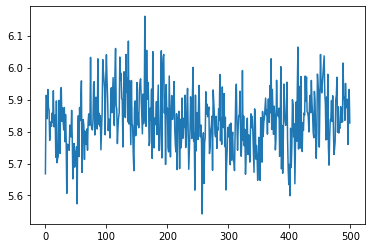

In [10]:
import matplotlib.pyplot as plt
plt.plot(lrmse)

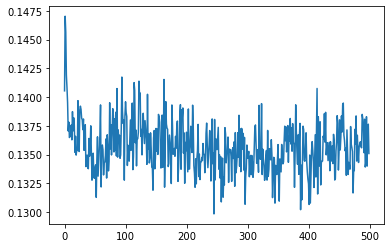

In [11]:
plt.plot(lmape)